# Data Cleaning, EDA, and Sarimax Model

https://github.com/sumants-dev/CIS545-Project/blob/main/Temperature_Time_Series_Analysis_v2.ipynb

# 4. Modelling

# 4.1 Pre-processing of Data for Modelling

In [1]:
%%capture
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java
!apt update
!apt install gcc python-dev libkrb5-dev

In [2]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [7]:
# Sklearn and Pandas Setup

import pandas as pd
print(pd.__version__ == '1.1.5')
import numpy as np 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
drive.mount('/content/drive')
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml-cisproject').getOrCreate()

True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [5]:
%load_ext sparkmagic.magics

In [8]:
co2_df = pd.read_csv('/content/drive/MyDrive/CIS 545/545 Project/global_average_yearly_temp_with_features_clean.csv')
co2_df.head(5)

,iso_code,year,oil_co2_per_capita,oil_co2,share_global_oil_co2,cumulative_oil_co2,share_global_cumulative_oil_co2,co2_growth_abs,co2_per_capita,co2,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_growth_prct,population,AvgYearlyTemp
0,FRA,1855,0.001,0.037,100.00,0.037,100.00,3.858,0.899,33.071,12.71,469.655,7.96,13.21,36768948.0,11.763583
1,FRA,1856,0.001,0.040,100.00,0.077,100.00,1.561,0.940,34.632,12.49,504.287,8.17,4.72,36853256.0,12.615917
2,FRA,1857,0.001,0.044,85.71,0.121,94.29,0.649,0.955,35.281,12.61,539.568,8.36,1.87,36937755.0,12.823250
3,FRA,1858,0.001,0.048,76.47,0.169,88.46,-0.685,0.934,34.595,12.17,574.163,8.52,-1.94,37022445.0,12.382083
4,FRA,1859,0.001,0.048,86.67,0.216,88.06,0.396,0.943,34.991,11.61,609.155,8.65,1.14,37110539.0,13.107500


In [9]:
iso_codes = co2_df['iso_code']
iso_codes_le = LabelEncoder()
iso_codes_le.fit(iso_codes)
co2_df['iso_code_labels'] = iso_codes_le.transform(co2_df['iso_code'])
co2_le_df = co2_df[['iso_code_labels', 'year', 'oil_co2_per_capita', 'oil_co2',
       'share_global_oil_co2', 'cumulative_oil_co2',
       'share_global_cumulative_oil_co2', 'co2_growth_abs', 'co2_per_capita',
       'co2', 'share_global_co2', 'cumulative_co2',
       'share_global_cumulative_co2', 'co2_growth_prct', 'population',
       'AvgYearlyTemp']]

In [10]:
co2_le_df.dtypes

iso_code_labels                      int64
year                                 int64
oil_co2_per_capita                 float64
oil_co2                            float64
share_global_oil_co2               float64
cumulative_oil_co2                 float64
share_global_cumulative_oil_co2    float64
co2_growth_abs                     float64
co2_per_capita                     float64
co2                                float64
share_global_co2                   float64
cumulative_co2                     float64
share_global_cumulative_co2        float64
co2_growth_prct                    float64
population                         float64
AvgYearlyTemp                      float64
dtype: object

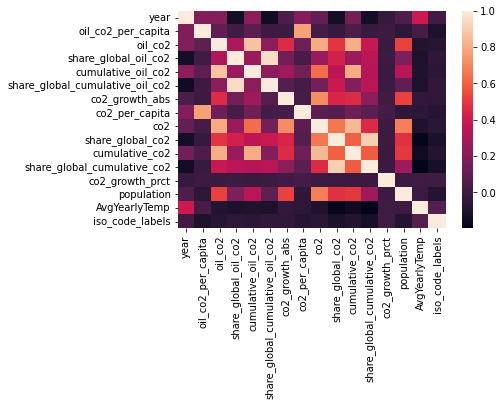

In [11]:
co2_corr = co2_df.corr()
sns.heatmap(co2_corr)

*   High correlation between cumulative_co2 and {oil_o2, cumulative_oil_co2}
*   High correlation between co2_per_capita and oil_co2_per_capita
*   Correlation between population and co2
*   Low correlation between AvgYearlyTemp and all features except year

In [12]:
combined_data_sec_2 = co2_le_df.copy()
combined_data_sec_2.rename(columns = {'views_log':'label'}, inplace = True) 
combined_data_sec_2.to_csv('/content/co2_le.csv')

In [13]:
co2_sdf = spark.read.csv("/content/co2_le.csv", header=True, inferSchema=True)
co2_sdf.show()

+---+---------------+----+------------------+--------------------+--------------------+--------------------+-------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+---------------------------+---------------+-----------+------------------+
|_c0|iso_code_labels|year|oil_co2_per_capita|             oil_co2|share_global_oil_co2|  cumulative_oil_co2|share_global_cumulative_oil_co2|      co2_growth_abs|      co2_per_capita|                 co2|share_global_co2|      cumulative_co2|share_global_cumulative_co2|co2_growth_prct| population|     AvgYearlyTemp|
+---+---------------+----+------------------+--------------------+--------------------+--------------------+-------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+---------------------------+---------------+-----------+------------------+
|  0|             53|1855|             0.001|0.03

In [14]:
co2_sdf.columns

['_c0',
 'iso_code_labels',
 'year',
 'oil_co2_per_capita',
 'oil_co2',
 'share_global_oil_co2',
 'cumulative_oil_co2',
 'share_global_cumulative_oil_co2',
 'co2_growth_abs',
 'co2_per_capita',
 'co2',
 'share_global_co2',
 'cumulative_co2',
 'share_global_cumulative_co2',
 'co2_growth_prct',
 'population',
 'AvgYearlyTemp']

# 4.2 Randomly Splitting Train and Test sets

## 4.2.1 No reduction of features

In [15]:
columns_to_use = ['iso_code_labels','year','oil_co2_per_capita','oil_co2','share_global_oil_co2',
                  'cumulative_oil_co2','share_global_cumulative_oil_co2','co2_growth_abs',
                  'co2_per_capita','co2','share_global_co2','cumulative_co2',
                  'share_global_cumulative_co2','co2_growth_prct','population']

In [18]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=columns_to_use, outputCol="features")

modified_data_sdf = assembler.transform(co2_sdf)
modified_data_sdf.show()

+---+---------------+----+------------------+--------------------+--------------------+--------------------+-------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+---------------------------+---------------+-----------+------------------+--------------------+
|_c0|iso_code_labels|year|oil_co2_per_capita|             oil_co2|share_global_oil_co2|  cumulative_oil_co2|share_global_cumulative_oil_co2|      co2_growth_abs|      co2_per_capita|                 co2|share_global_co2|      cumulative_co2|share_global_cumulative_co2|co2_growth_prct| population|     AvgYearlyTemp|            features|
+---+---------------+----+------------------+--------------------+--------------------+--------------------+-------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+---------------------------+---------------+-----------+------------------+--------

In [19]:
train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8, 0.2], seed=24)

### Linear Regression

##### No regularization

In [20]:
from pyspark.ml.regression import LinearRegression

# TODO define model
lr = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=5, regParam=0, elasticNetParam = 0)


# fit on training data
clfModel = lr.fit(train_sdf)

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator

# prediction and evaluation
prediction = clfModel.transform(train_sdf)
evaluator = RegressionEvaluator()
evaluator.setPredictionCol('prediction')
evaluator.setLabelCol('AvgYearlyTemp')

RegressionEvaluator_d235f56e9f60

In [ ]:
lr_training_mae = evaluator.evaluate(prediction, {evaluator.metricName: "mae"})
lr_training_mse = evaluator.evaluate(prediction, {evaluator.metricName: "mse"})
lr_test_prediction = clfModel.transform(test_sdf)
lr_test_mae = evaluator.evaluate(lr_test_prediction, {evaluator.metricName: "mae"})
lr_test_mse = evaluator.evaluate(lr_test_prediction, {evaluator.metricName: "mse"})

print("training mse:",lr_training_mse, "    training mae:", lr_training_mae)
print("    test mse:",lr_test_mse, "        test mae:", lr_test_mae)

training mse: 69.88982640680005     training mae: 6.712819691130782
    test mse: 66.79354730406963         test mae: 6.545596668984783


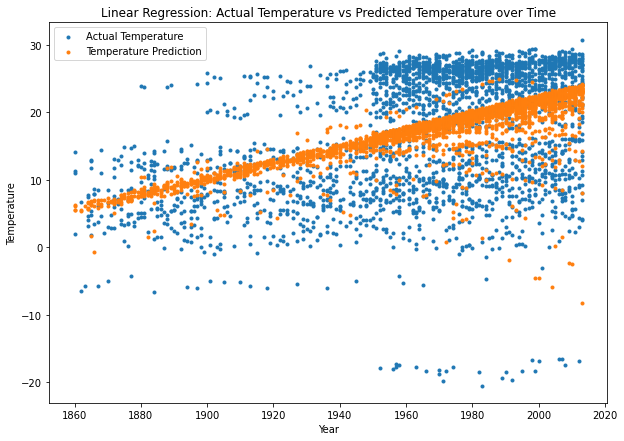

In [ ]:
lr_df = lr_test_prediction.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(lr_df['year'], lr_df['AvgYearlyTemp'], label = 'Actual Temperature', marker = '.')
plt.scatter(lr_df['year'], lr_df['prediction'], label="Temperature Prediction", marker = '.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Linear Regression: Actual Temperature vs Predicted Temperature over Time")
plt.show()

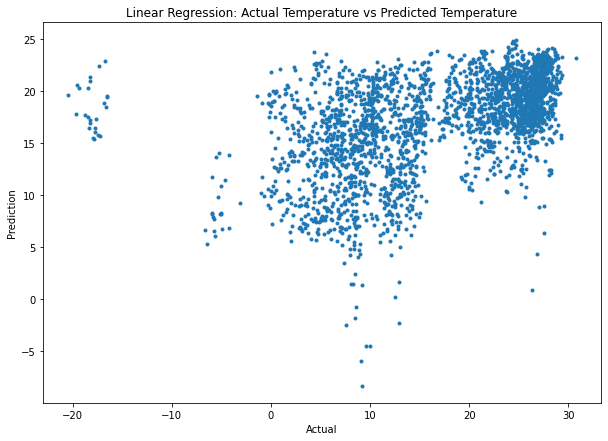

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(lr_df['AvgYearlyTemp'], lr_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression: Actual Temperature vs Predicted Temperature")
plt.show()


##### Regularization

###### Lasso

In [ ]:
# LASSO L1
lasso = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=10, regParam=0, elasticNetParam = 1)
lassoModel = lasso.fit(train_sdf)
prediction = lassoModel.transform(train_sdf)
lasso_test_prediction = lassoModel.transform(test_sdf)
l1_mse = evaluator.evaluate(lasso_test_prediction, {evaluator.metricName: "mse"})
l1_mae = evaluator.evaluate(lasso_test_prediction, {evaluator.metricName: "mae"})
print("lasso test mse:",l1_mse, "          lasso test mae:", l1_mae)

lasso test mse: 66.79354730406963           lasso test mae: 6.545596668984783


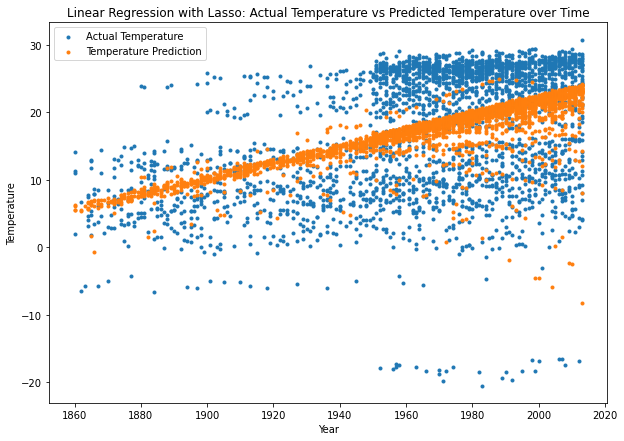

In [ ]:
# Plotting Lasso
lr_lasso_df = lasso_test_prediction.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(lr_lasso_df['year'], lr_lasso_df['AvgYearlyTemp'], label = 'Actual Temperature', marker = '.')
plt.scatter(lr_lasso_df['year'], lr_lasso_df['prediction'], label="Temperature Prediction", marker = '.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Linear Regression with Lasso: Actual Temperature vs Predicted Temperature over Time")
plt.show()

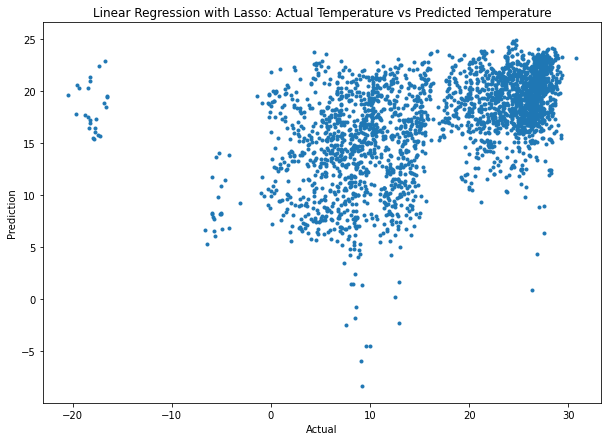

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(lr_lasso_df['AvgYearlyTemp'], lr_lasso_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression with Lasso: Actual Temperature vs Predicted Temperature")
plt.show()

###### Ridge

In [ ]:
# RIDGE L2
ridge = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=10, regParam=1, elasticNetParam = 0)
ridgeModel = ridge.fit(train_sdf)
prediction = ridgeModel.transform(train_sdf)
ridge_test_prediction = ridgeModel.transform(test_sdf)
l2_mse = evaluator.evaluate(ridge_test_prediction, {evaluator.metricName: "mse"})
l2_mae = evaluator.evaluate(ridge_test_prediction, {evaluator.metricName: "mae"})
print("ridge test mse:",l2_mse, "          ridge test mae:", l2_mae)

ridge test mse: 67.51166289962879           ridge test mae: 6.687138370982423


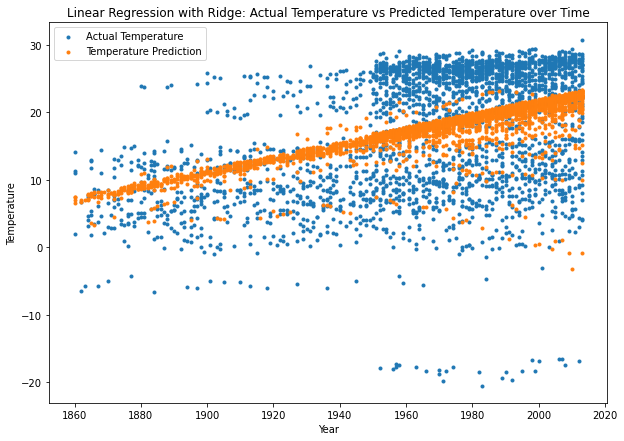

In [ ]:
# Plotting Ridge
lr_ridge_df = ridge_test_prediction.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(lr_ridge_df['year'], lr_ridge_df['AvgYearlyTemp'], label = 'Actual Temperature', marker = '.')
plt.scatter(lr_ridge_df['year'], lr_ridge_df['prediction'], label="Temperature Prediction", marker = '.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Linear Regression with Ridge: Actual Temperature vs Predicted Temperature over Time")
plt.show()

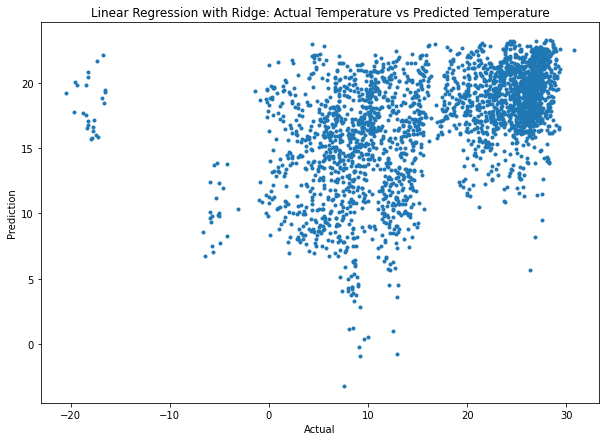

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(lr_ridge_df['AvgYearlyTemp'], lr_ridge_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression with Ridge: Actual Temperature vs Predicted Temperature")
plt.show()

###### Elastic Net

In [ ]:
# Elastic Net
elastic = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=10, regParam=1, elasticNetParam = 1)
elasticModel = elastic.fit(train_sdf)
prediction = elasticModel.transform(train_sdf)
elastic_test_prediction = elasticModel.transform(test_sdf)
elastic_mse = evaluator.evaluate(elastic_test_prediction, {evaluator.metricName: "mse"})
elastic_mae = evaluator.evaluate(elastic_test_prediction, {evaluator.metricName: "mae"})
print("elastic net test mse:",elastic_mse, "    elastic net test mae:", elastic_mae)

elastic net test mse: 72.08868110916873     elastic net test mae: 7.09884759707322


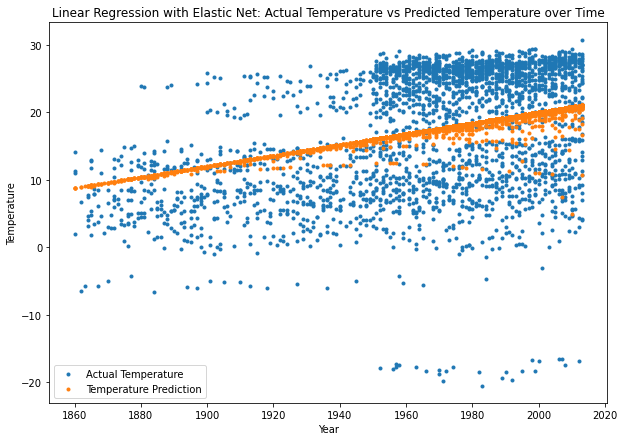

In [ ]:
# Plotting elastic net
lr_elastic_df = elastic_test_prediction.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(lr_elastic_df['year'], lr_elastic_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(lr_elastic_df['year'], lr_elastic_df['prediction'], label="Temperature Prediction", marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='lower left')
plt.title("Linear Regression with Elastic Net: Actual Temperature vs Predicted Temperature over Time")
plt.show()

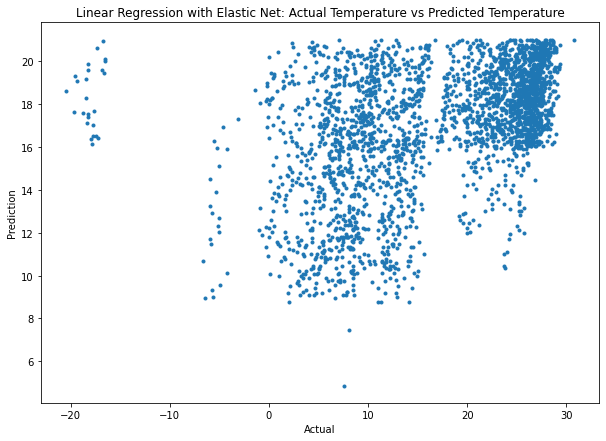

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(lr_elastic_df['AvgYearlyTemp'], lr_elastic_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression with Elastic Net: Actual Temperature vs Predicted Temperature")
plt.show()

### Random Forest Regression

In [ ]:
# Tuning Random Forest Regression parameters
from pyspark.ml.regression import RandomForestRegressor

max_Depth = [5, 10, 30]
num_Trees = [10, 30, 50]
for i in range(3):
  rfc = RandomForestRegressor(featuresCol="features",labelCol="AvgYearlyTemp", maxDepth = max_Depth[i], numTrees = num_Trees[i])
  rfModel = rfc.fit(train_sdf)
  rf_train_prediction = rfModel.transform(train_sdf)
  rf_test_prediction = rfModel.transform(test_sdf)
  test_mse = evaluator.evaluate(rf_test_prediction, {evaluator.metricName: "mse"})
  test_mae = evaluator.evaluate(rf_test_prediction, {evaluator.metricName: "mae"})
  print("max depth:",max_Depth[i]," num trees:", num_Trees[i], " test mse:", test_mse, "test mae:", test_mae)

max depth: 5  num trees: 10  test mse: 35.54450111625699 test mae: 4.3680266476254825
max depth: 10  num trees: 30  test mse: 7.112428306064108 test mae: 1.9007951626573576
max depth: 30  num trees: 50  test mse: 2.1069435789917663 test mae: 0.842168909709961


In [ ]:
# max depth: 30, max_trees: 50
rfc = RandomForestRegressor(featuresCol="features",labelCol="AvgYearlyTemp", maxDepth = 30, numTrees=50)

# fit on training data
rfModel = rfc.fit(train_sdf)

In [ ]:
# predictions
rf_train_prediction = rfModel.transform(train_sdf)
rf_test_prediction = rfModel.transform(test_sdf)

# evaluate predictions
train_mse = evaluator.evaluate(rf_train_prediction, {evaluator.metricName: "mse"})
train_mae = evaluator.evaluate(rf_train_prediction, {evaluator.metricName: "mae"})
test_mse = evaluator.evaluate(rf_test_prediction, {evaluator.metricName: "mse"})
test_mae = evaluator.evaluate(rf_test_prediction, {evaluator.metricName: "mae"})
print("train mse:", train_mse, "train mae:", train_mae)
print(" test mse:", test_mse, " test mae:", test_mae)

train mse: 0.38575439142983886 train mae: 0.3502620590083311
 test mse: 2.1069435789917663  test mae: 0.842168909709961


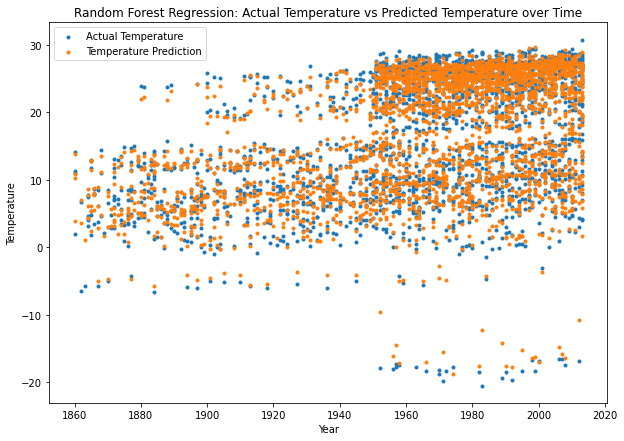

In [ ]:
# Plotting random forest regressor
rf_df = rf_test_prediction.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(rf_df['year'], rf_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(rf_df['year'], rf_df['prediction'], label="Temperature Prediction", marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Random Forest Regression: Actual Temperature vs Predicted Temperature over Time")
plt.show()

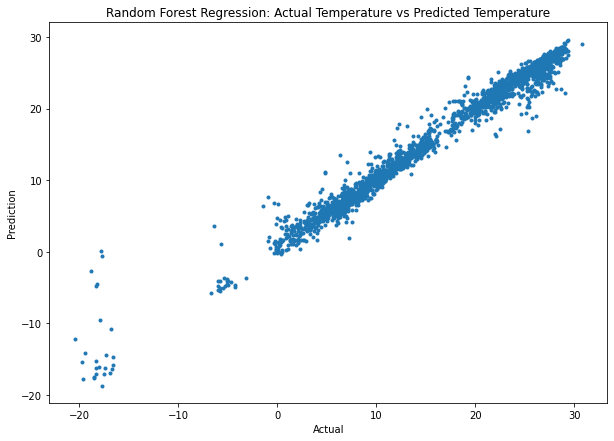

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(rf_df['AvgYearlyTemp'], rf_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Random Forest Regression: Actual Temperature vs Predicted Temperature")
plt.show()

## 4.2.2 Using PCA to reduce features

Find the k value

In [ ]:
# split training x, y
training_df = train_sdf.toPandas()
training_x = training_df[['iso_code_labels', 'year', 'oil_co2_per_capita', 
            'oil_co2', 'share_global_oil_co2', 'cumulative_oil_co2',
            'share_global_cumulative_oil_co2', 'co2_growth_abs', 
            'co2_per_capita', 'co2', 'share_global_co2', 'cumulative_co2',
            'share_global_cumulative_co2', 'co2_growth_prct', 'population']]
training_y = training_df['AvgYearlyTemp']

# split test x, y
testing_df = test_sdf.toPandas()
testing_x = testing_df[['iso_code_labels', 'year', 'oil_co2_per_capita', 
            'oil_co2', 'share_global_oil_co2', 'cumulative_oil_co2',
            'share_global_cumulative_oil_co2', 'co2_growth_abs', 
            'co2_per_capita', 'co2', 'share_global_co2', 'cumulative_co2',
            'share_global_cumulative_co2', 'co2_growth_prct', 'population']]
testing_y = testing_df['AvgYearlyTemp']

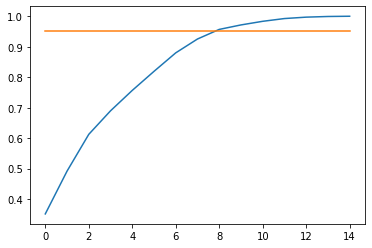

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_training_x = scaler.fit_transform(training_x)
scaled_testing_x = scaler.transform(testing_x)

from sklearn.decomposition import PCA
pca = PCA(n_components=15)
x_train_pca = pca.fit_transform(scaled_training_x)
x_test_pca = pca.transform(scaled_testing_x)
pca_components = pca.components_

# Explained variance
np.set_printoptions(suppress=True)
pca_ratio = pca.explained_variance_ratio_
plt.plot(np.arange(0, 15), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(0, 15), [0.95]*15)
plt.show()

In [ ]:
# Set PCA k value as 8
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA

pca = PCA(k=8, inputCol="features", outputCol="pcaFeatures")

##### Linear Regression

In [ ]:
# Set up PCA using Lasso Linear Regression
pca_lr = LinearRegression(featuresCol='pcaFeatures',labelCol='AvgYearlyTemp',maxIter=10, regParam=0, elasticNetParam = 1)
# Fit the model using the training data
pca_lr_pipe = Pipeline(stages=[assembler,pca, pca_lr])

In [ ]:
# Get the PCA feature from the trained model
pca_lr_train_sdf = train_sdf.drop("features")
pca_lr_model = pca_lr_pipe.fit(pca_lr_train_sdf)

In [ ]:
# Train a logistic regression model using the PCA features
pca_lr_train_prediction = pca_lr_model.transform(pca_lr_train_sdf)

pca_lr_test_sdf = test_sdf.drop("features")
pca_lr_test_prediction = pca_lr_model.transform(pca_lr_test_sdf)

In [ ]:
# evaluate predictions
pca_training_mse = evaluator.evaluate(pca_lr_train_prediction, {evaluator.metricName: "mse"})
pca_training_mae = evaluator.evaluate(pca_lr_train_prediction, {evaluator.metricName: "mae"})
pca_test_mse = evaluator.evaluate(pca_lr_test_prediction, {evaluator.metricName: "mse"})
pca_test_mae = evaluator.evaluate(pca_lr_test_prediction, {evaluator.metricName: "mae"})
print("training mse:", pca_training_mse, "   training mae:", pca_training_mae)
print("    test mse:", pca_test_mse, "       test mae:", pca_test_mae)

training mse: 71.53294807456044    training mae: 6.853914861130977
    test mse: 68.55450343625094        test mae: 6.688520802435175


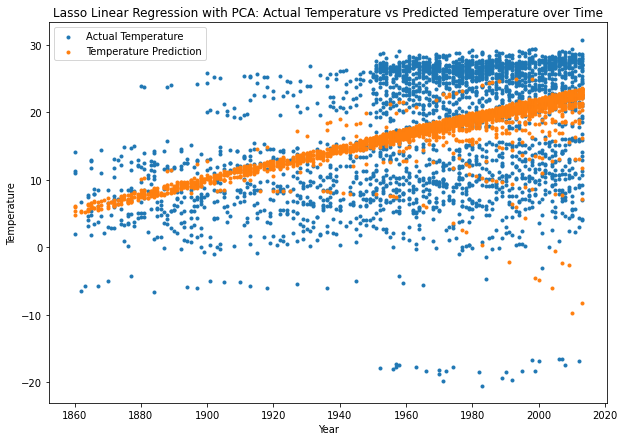

In [ ]:
# Plot PCA
pca_lr_df = pca_lr_test_prediction.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(pca_lr_df['year'], pca_lr_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(pca_lr_df['year'], pca_lr_df['prediction'], label="Temperature Prediction",marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Lasso Linear Regression with PCA: Actual Temperature vs Predicted Temperature over Time")
plt.show()

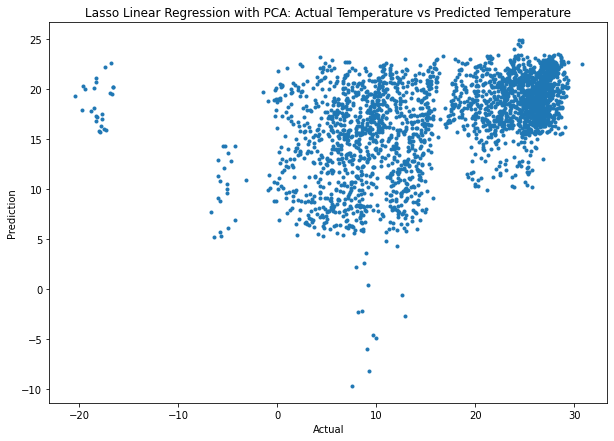

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_lr_df['AvgYearlyTemp'], pca_lr_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Lasso Linear Regression with PCA: Actual Temperature vs Predicted Temperature")
plt.show()

##### Random Forest Regression

In [ ]:
# Set up PCA using Lasso Linear Regression
pca_rf = RandomForestRegressor(featuresCol="pcaFeatures",labelCol="AvgYearlyTemp", maxDepth = 30, numTrees=50)
# Fit the model using the training data
pca_rf_pipe = Pipeline(stages=[assembler,pca, pca_rf])

In [ ]:
# Get the PCA feature from the trained model
pca_rf_train_sdf = train_sdf.drop("features")
pca_model = pca_rf_pipe.fit(pca_rf_train_sdf)

In [ ]:
# Train a random forest regression model using the PCA features
pca_rf_train_prediction = pca_model.transform(pca_rf_train_sdf)

pca_rf_test_sdf = test_sdf.drop("features")
pca_rf_test_prediction = pca_model.transform(pca_rf_test_sdf)

In [ ]:
# evaluate predictions
pca_rf_training_mse = evaluator.evaluate(pca_rf_train_prediction, {evaluator.metricName: "mse"})
pca_rf_training_mae = evaluator.evaluate(pca_rf_train_prediction, {evaluator.metricName: "mae"})
pca_rf_test_mse = evaluator.evaluate(pca_rf_test_prediction, {evaluator.metricName: "mse"})
pca_rf_test_mae = evaluator.evaluate(pca_rf_test_prediction, {evaluator.metricName: "mae"})
print("training mse:", pca_rf_training_mse, "   training mae:", pca_rf_training_mae)
print("    test mse:", pca_rf_test_mse, "       test mae:", pca_rf_test_mae)

training mse: 0.4479611367248118    training mae: 0.38936801011695016
    test mse: 2.2605130449629387        test mae: 0.8668084944204577


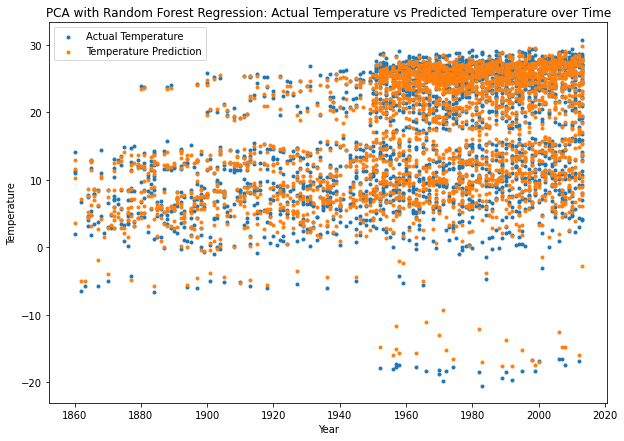

In [ ]:
# Plot PCA
pca_rf_df = pca_rf_test_prediction.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(pca_rf_df['year'], pca_rf_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(pca_rf_df['year'], pca_rf_df['prediction'], label="Temperature Prediction",marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("PCA with Random Forest Regression: Actual Temperature vs Predicted Temperature over Time")
plt.show()

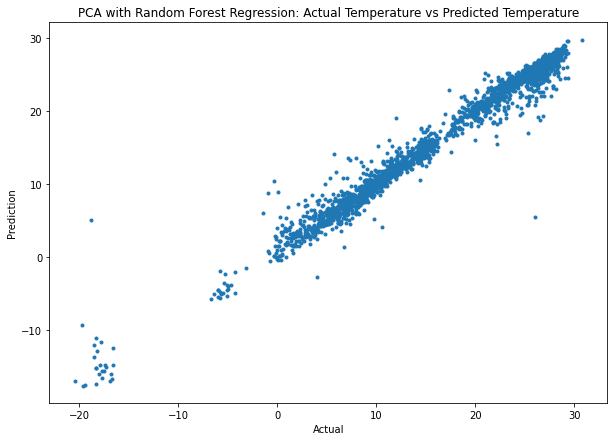

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_rf_df['AvgYearlyTemp'], pca_rf_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("PCA with Random Forest Regression: Actual Temperature vs Predicted Temperature")
plt.show()

## 4.2.3 Reduction of features without PCA

In [ ]:
# remove duplicate columns
columns_to_use_2 = ['iso_code_labels','year','co2','co2_growth_prct','population']
modified_co2_sdf = co2_sdf['iso_code_labels','year','co2','co2_growth_prct','population','AvgYearlyTemp']

In [ ]:
assembler2 = VectorAssembler(inputCols=columns_to_use_2, outputCol="features")

In [ ]:
from pyspark.ml import Pipeline

modified_co2_sdf = assembler2.transform(modified_co2_sdf)
modified_co2_sdf.show()

+---------------+----+--------------------+---------------+-----------+------------------+--------------------+
|iso_code_labels|year|                 co2|co2_growth_prct| population|     AvgYearlyTemp|            features|
+---------------+----+--------------------+---------------+-----------+------------------+--------------------+
|             53|1855|              33.071|          13.21|3.6768948E7|11.763583333333335|[53.0,1855.0,33.0...|
|             53|1856|              34.632|           4.72|3.6853256E7|12.615916666666665|[53.0,1856.0,34.6...|
|             53|1857|              35.281|           1.87|3.6937755E7|12.823250000000002|[53.0,1857.0,35.2...|
|             53|1858|              34.595|          -1.94|3.7022445E7|12.382083333333336|[53.0,1858.0,34.5...|
|             53|1859|              34.991|           1.14|3.7110539E7|           13.1075|[53.0,1859.0,34.9...|
|            136|1859|               0.004|            0.0|  8499134.0| 9.252083333333333|[136.0,1859.0,

In [ ]:
train_sdf_2, test_sdf_2 = modified_co2_sdf.randomSplit([0.8, 0.2], seed=24)

### Linear Regression

#### No regularization

In [ ]:
# Regular Linear Regression
# fit on training data
lr_2 = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=10, regParam=0, elasticNetParam = 0)
clfModel_2 = lr_2.fit(train_sdf_2)
lr_training_prediction_2 = clfModel_2.transform(train_sdf_2)
lr_training_mse_2 = evaluator.evaluate(lr_training_prediction_2, {evaluator.metricName: "mse"})
lr_training_mae_2 = evaluator.evaluate(lr_training_prediction_2, {evaluator.metricName: "mae"})
lr_test_prediction_2 = clfModel_2.transform(test_sdf_2)
lr_test_mse_2 = evaluator.evaluate(lr_test_prediction_2, {evaluator.metricName: "mse"})
lr_test_mae_2 = evaluator.evaluate(lr_test_prediction_2, {evaluator.metricName: "mae"})

print("training mse:", lr_training_mse_2, "  training mae:", lr_training_mae_2)
print("    test mse:", lr_test_mse_2, "      test mae:", lr_test_mae_2)

training mse: 72.68465473335785   training mae: 6.938894040959976
    test mse: 73.46010710006405       test mae: 6.87475433144544


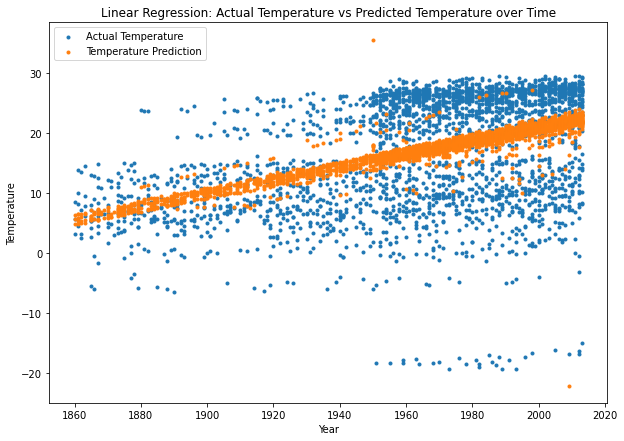

In [ ]:
lr_2_df = lr_test_prediction_2.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(lr_2_df['year'], lr_2_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(lr_2_df['year'], lr_2_df['prediction'], label="Temperature Prediction", marker = '.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Linear Regression: Actual Temperature vs Predicted Temperature over Time")
plt.show()

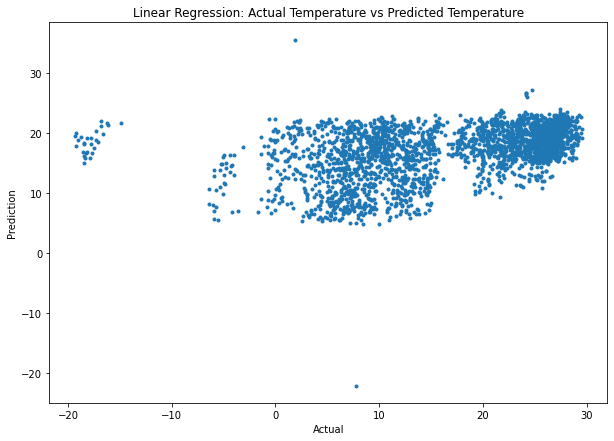

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(lr_2_df['AvgYearlyTemp'], lr_2_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression: Actual Temperature vs Predicted Temperature")
plt.show()

#### Regularization

##### Lasso

In [ ]:
# LASSO L1
lasso_2 = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=10, regParam=0, elasticNetParam = 1)
lassoModel_2 = lasso_2.fit(train_sdf_2)
lasso_training_prediction_2 = lassoModel_2.transform(train_sdf_2)
lasso_test_prediction_2 = lassoModel_2.transform(test_sdf_2)
lasso_test_prediction_2_mse = evaluator.evaluate(lasso_test_prediction_2, {evaluator.metricName: "mse"})
lasso_test_prediction_2_mae = evaluator.evaluate(lasso_test_prediction_2, {evaluator.metricName: "mae"})
print("lasso test mse:", lasso_test_prediction_2_mse, "    lasso test mae:", lasso_test_prediction_2_mae)

lasso test mse: 73.46010710006405     lasso test mae: 6.87475433144544


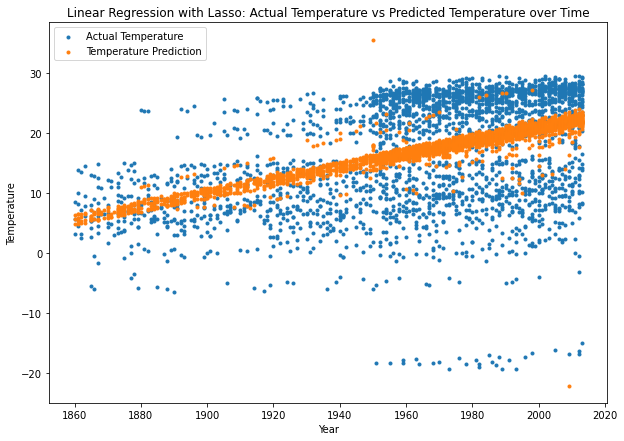

In [ ]:
lasso_2_df = lasso_test_prediction_2.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(lasso_2_df['year'], lasso_2_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(lasso_2_df['year'], lasso_2_df['prediction'], label="Temperature Prediction", marker ='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Linear Regression with Lasso: Actual Temperature vs Predicted Temperature over Time")
plt.show()

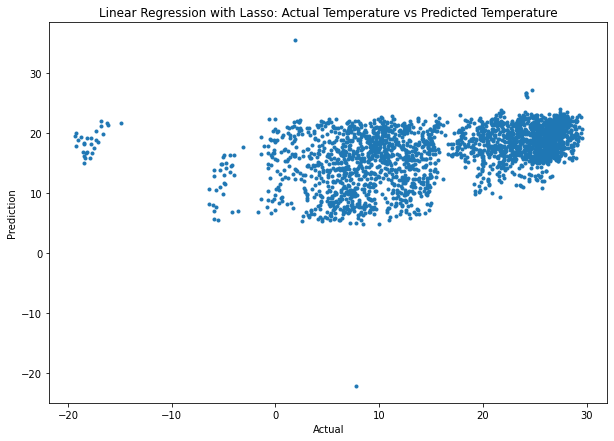

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(lasso_2_df['AvgYearlyTemp'], lasso_2_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression with Lasso: Actual Temperature vs Predicted Temperature")
plt.show()

##### Ridge

In [ ]:
# RIDGE L2
ridge_2 = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=10, regParam=1, elasticNetParam = 0)
ridgeModel_2 = ridge_2.fit(train_sdf_2)
ridge_training_prediction_2 = ridgeModel_2.transform(train_sdf_2)
ridge_test_prediction_2 = ridgeModel_2.transform(test_sdf_2)
ridge_test_prediction_2_mse = evaluator.evaluate(ridge_test_prediction_2, {evaluator.metricName: "mse"})
ridge_test_prediction_2_mae = evaluator.evaluate(ridge_test_prediction_2, {evaluator.metricName: "mae"})
print("ridge test mse:", ridge_test_prediction_2_mse, '    ridge test mae:', ridge_test_prediction_2_mae)

ridge test mse: 73.8997774585495     ridge test mae: 6.973080921492441


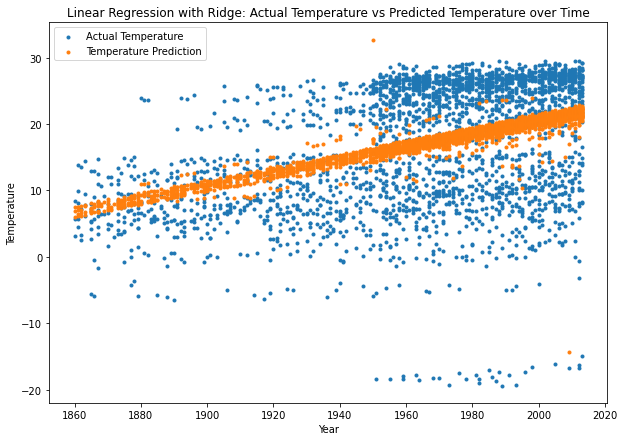

In [ ]:
ridge_2_df = ridge_test_prediction_2.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(ridge_2_df['year'], ridge_2_df['AvgYearlyTemp'], label = 'Actual Temperature', marker = '.')
plt.scatter(ridge_2_df['year'], ridge_2_df['prediction'], label="Temperature Prediction", marker = '.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Linear Regression with Ridge: Actual Temperature vs Predicted Temperature over Time")
plt.show()

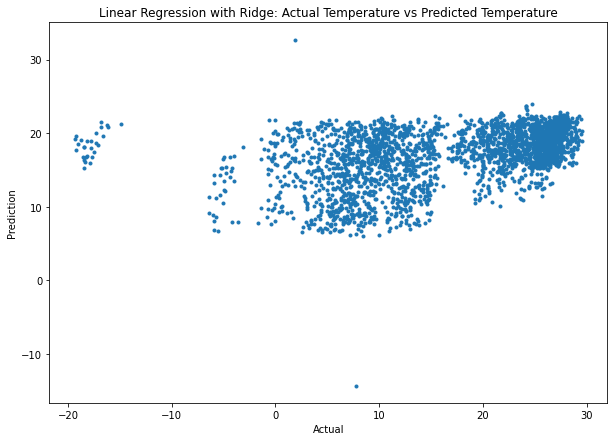

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(ridge_2_df['AvgYearlyTemp'], ridge_2_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression with Ridge: Actual Temperature vs Predicted Temperature")
plt.show()

##### Elastic Net

In [ ]:
# elastic net
elastic_2 = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=10, regParam=1, elasticNetParam = 1)
elasticModel_2 = elastic_2.fit(train_sdf_2)
elastic_training_prediction_2 = elasticModel_2.transform(train_sdf_2)
elastic_test_prediction_2 = elasticModel_2.transform(test_sdf_2)
elastic_test__prediction_2_mse = evaluator.evaluate(elastic_test_prediction_2, {evaluator.metricName: "mse"})
elastic_test__prediction_2_mae = evaluator.evaluate(elastic_test_prediction_2, {evaluator.metricName: "mae"})
print("elastic test mse:", elastic_test__prediction_2_mse, '  elastic test mae:', elastic_test__prediction_2_mae)

elastic test mse: 76.91491901033511   elastic test mae: 7.29139794321026


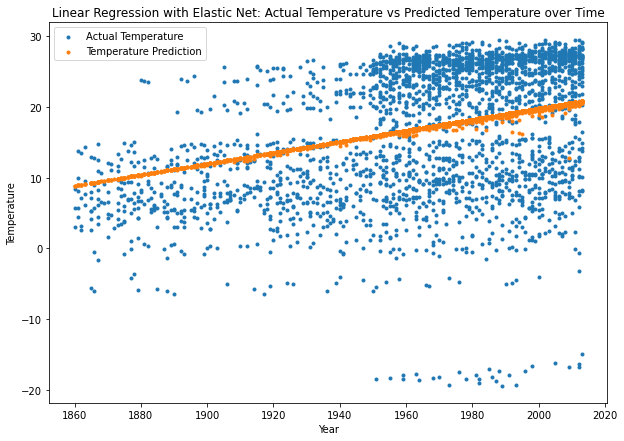

In [ ]:
elastic_2_df = elastic_test_prediction_2.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(elastic_2_df['year'], elastic_2_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(elastic_2_df['year'], elastic_2_df['prediction'], label="Temperature Prediction", marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Linear Regression with Elastic Net: Actual Temperature vs Predicted Temperature over Time")
plt.show()

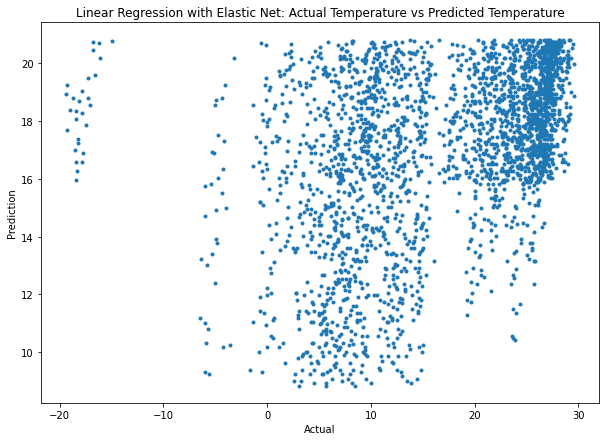

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(elastic_2_df['AvgYearlyTemp'], elastic_2_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression with Elastic Net: Actual Temperature vs Predicted Temperature")
plt.show()

### Random Forest Regression

In [ ]:
# tuning RF model
from pyspark.ml.regression import RandomForestRegressor

max_Depth = [5, 10, 30]
num_Trees = [10, 30, 50]
for i in range(3):
  rfc = RandomForestRegressor(featuresCol="features",labelCol="AvgYearlyTemp", maxDepth = max_Depth[i], numTrees = num_Trees[i])
  rfModel = rfc.fit(train_sdf_2)
  rf_train_prediction = rfModel.transform(train_sdf_2)
  rf_test_prediction = rfModel.transform(test_sdf_2)
  test_mse = evaluator.evaluate(rf_test_prediction, {evaluator.metricName: "mse"})
  test_mae = evaluator.evaluate(rf_test_prediction, {evaluator.metricName: "mae"})
  print("max depth:",max_Depth[i]," num trees:", num_Trees[i], " test mse:", test_mse, "test mae:", test_mae)

max depth: 5  num trees: 10  test mse: 44.11895913569629 test mae: 5.0652728799816895
max depth: 10  num trees: 30  test mse: 13.812453861103643 test mae: 2.578997464944342
max depth: 30  num trees: 50  test mse: 4.384817334569455 test mae: 1.2378777194501158


In [ ]:
rfc_2 = RandomForestRegressor(featuresCol="features",labelCol="AvgYearlyTemp", maxDepth = 30, numTrees=50)
rfModel_2 = rfc_2.fit(train_sdf_2)
rf_train_prediction_2 = rfModel_2.transform(train_sdf_2)
rf_test_prediction_2 = rfModel_2.transform(test_sdf_2)
rf_train_prediction_mse_2 = evaluator.evaluate(rf_train_prediction_2, {evaluator.metricName: "mse"})
rf_train_prediction_mae_2 = evaluator.evaluate(rf_train_prediction_2, {evaluator.metricName: "mae"})
rf_test_prediction_mse_2 = evaluator.evaluate(rf_test_prediction_2, {evaluator.metricName: "mse"})
rf_test_prediction_mae_2 = evaluator.evaluate(rf_test_prediction_2, {evaluator.metricName: "mae"})

print("training mse:",rf_train_prediction_mse_2, "    training mae:", rf_train_prediction_mae_2)
print("    test mse:",rf_test_prediction_mse_2, "          test mae:", rf_test_prediction_mae_2)

training mse: 0.8617742487871101     training mae: 0.5316585552863046
    test mse: 4.384817334569455           test mae: 1.2378777194501158


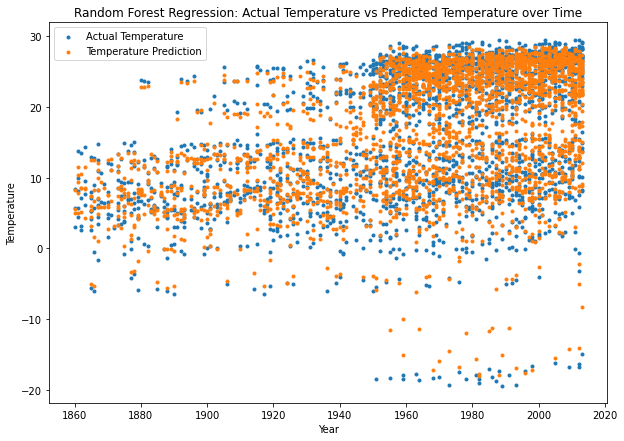

In [ ]:
rf_2_df = rf_test_prediction_2.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(rf_2_df['year'], rf_2_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(rf_2_df['year'], rf_2_df['prediction'], label="Temperature Prediction", marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Random Forest Regression: Actual Temperature vs Predicted Temperature over Time")
plt.show()

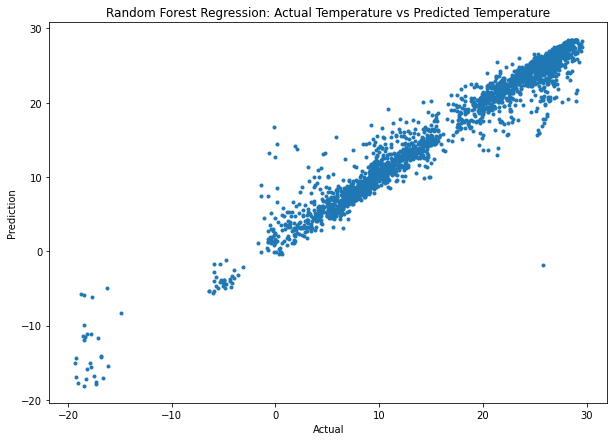

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(rf_2_df['AvgYearlyTemp'], rf_2_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Random Forest Regression: Actual Temperature vs Predicted Temperature")
plt.show()

# 4.3 Splitting Train/Test set by Year

Training and Validation (1750 - 1980) and Testing (1980 - 2013)

### 4.3.1 No reduction of features

In [22]:
training_sdf = modified_data_sdf[modified_data_sdf['year'] < 1980]
training_sdf.show()

+---+---------------+----+------------------+--------------------+--------------------+--------------------+-------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+---------------------------+---------------+-----------+------------------+--------------------+
|_c0|iso_code_labels|year|oil_co2_per_capita|             oil_co2|share_global_oil_co2|  cumulative_oil_co2|share_global_cumulative_oil_co2|      co2_growth_abs|      co2_per_capita|                 co2|share_global_co2|      cumulative_co2|share_global_cumulative_co2|co2_growth_prct| population|     AvgYearlyTemp|            features|
+---+---------------+----+------------------+--------------------+--------------------+--------------------+-------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+---------------------------+---------------+-----------+------------------+--------

In [23]:
testing_sdf = modified_data_sdf[modified_data_sdf['year'] >= 1980]
testing_sdf.show()

+----+---------------+----+------------------+-------------------+--------------------+------------------+-------------------------------+--------------------+------------------+-------------------+----------------+------------------+---------------------------+---------------+-----------+------------------+--------------------+
| _c0|iso_code_labels|year|oil_co2_per_capita|            oil_co2|share_global_oil_co2|cumulative_oil_co2|share_global_cumulative_oil_co2|      co2_growth_abs|    co2_per_capita|                co2|share_global_co2|    cumulative_co2|share_global_cumulative_co2|co2_growth_prct| population|     AvgYearlyTemp|            features|
+----+---------------+----+------------------+-------------------+--------------------+------------------+-------------------------------+--------------------+------------------+-------------------+----------------+------------------+---------------------------+---------------+-----------+------------------+--------------------+
|7763| 

#### Linear Regression

##### No Regularization

In [24]:
# Regular Linear Regression
lr_3 = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=10, regParam=0, elasticNetParam = 0)
clfModel_3 = lr_3.fit(training_sdf)
lr_training_prediction_3 = clfModel_3.transform(training_sdf)
lr_training_mse_3 = evaluator.evaluate(lr_training_prediction_3, {evaluator.metricName: "mse"})
lr_training_mae_3 = evaluator.evaluate(lr_training_prediction_3, {evaluator.metricName: "mae"})
lr_test_prediction_3 = clfModel_3.transform(testing_sdf)
lr_test_mse_3 = evaluator.evaluate(lr_test_prediction_3, {evaluator.metricName: "mse"})
lr_test_mae_3 = evaluator.evaluate(lr_test_prediction_3, {evaluator.metricName: "mae"})

print("training mse:", lr_training_mse_3, "  training mae:", lr_training_mae_3)
print("    test mse:", lr_test_mse_3, "      test mae:", lr_test_mae_3)

training mse: 62.974394026315075   training mae: 6.373988062215199
    test mse: 292.21529280795596       test mae: 8.10532667903945


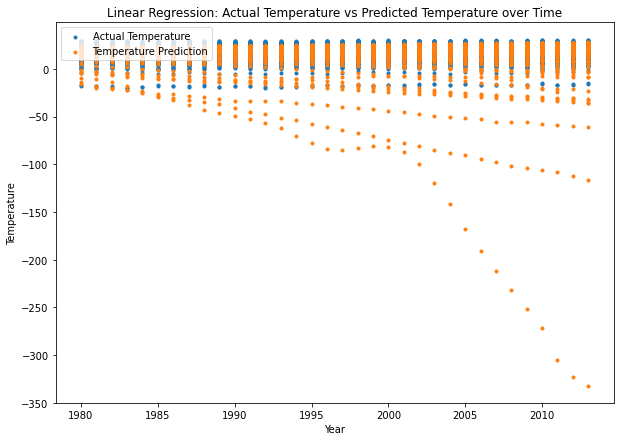

In [25]:
lr_3_df = lr_test_prediction_3.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(lr_3_df['year'], lr_3_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(lr_3_df['year'], lr_3_df['prediction'], label="Temperature Prediction", marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Linear Regression: Actual Temperature vs Predicted Temperature over Time")
plt.show()

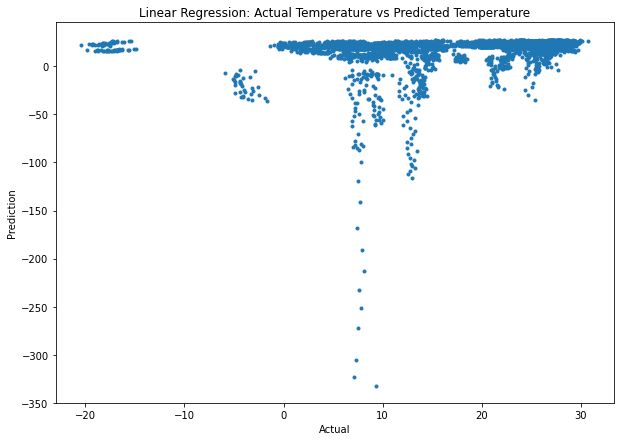

In [26]:
plt.figure(figsize=(10, 7))
plt.scatter(lr_3_df['AvgYearlyTemp'], lr_3_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression: Actual Temperature vs Predicted Temperature")
plt.show()

##### Regularization

###### Lasso

In [27]:
# LASSO L1
lasso_3 = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=10, regParam=0, elasticNetParam = 1)
lassoModel_3 = lasso_3.fit(training_sdf)
lasso_training_prediction_3 = lassoModel_3.transform(training_sdf)
lasso_test_prediction_3 = lassoModel_3.transform(testing_sdf)
lasso_training_prediction_3_mse = evaluator.evaluate(lasso_training_prediction_3, {evaluator.metricName: "mse"})
lasso_training_prediction_3_mae = evaluator.evaluate(lasso_training_prediction_3, {evaluator.metricName: "mae"})
lasso_test_prediction_3_mse = evaluator.evaluate(lasso_test_prediction_3, {evaluator.metricName: "mse"})
lasso_test_prediction_3_mae = evaluator.evaluate(lasso_test_prediction_3, {evaluator.metricName: "mae"})

print("lasso training mse:", lasso_training_prediction_3_mse, '    lasso training mae:', lasso_training_prediction_3_mae)
print("    lasso test mse:", lasso_test_prediction_3_mse, '        lasso test mae:', lasso_test_prediction_3_mae)

lasso training mse: 62.974394026315075     lasso training mae: 6.373988062215199
    lasso test mse: 292.21529280795596         lasso test mae: 8.10532667903945


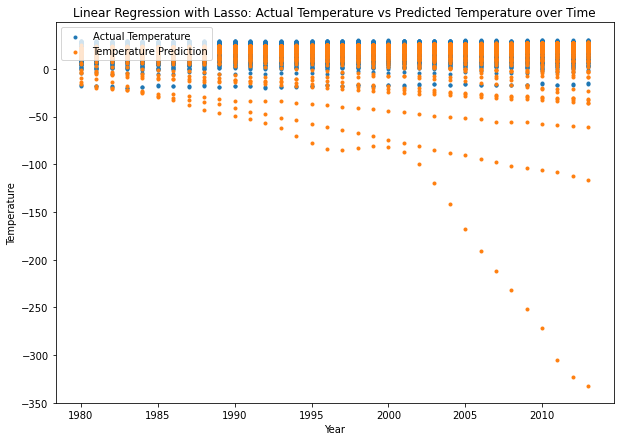

In [28]:
lasso_3_df = lasso_test_prediction_3.toPandas()
testing_df = testing_sdf.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(testing_df['year'], testing_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(lasso_3_df['year'], lasso_3_df['prediction'], label="Temperature Prediction", marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Linear Regression with Lasso: Actual Temperature vs Predicted Temperature over Time")
plt.show()

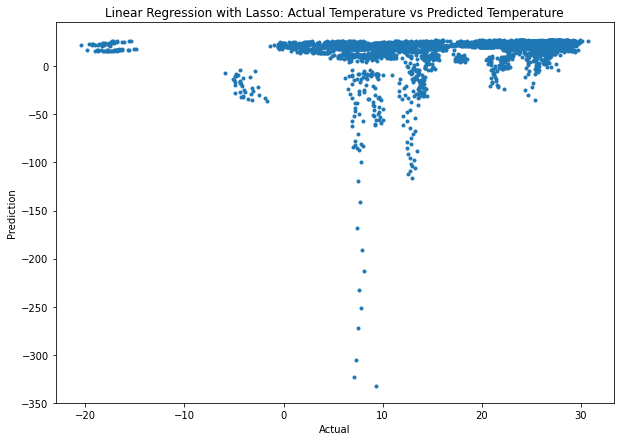

In [29]:
plt.figure(figsize=(10, 7))
plt.scatter(lasso_3_df['AvgYearlyTemp'], lasso_3_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression with Lasso: Actual Temperature vs Predicted Temperature")
plt.show()

###### Ridge

In [33]:
# RIDGE L2
ridge_3 = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=10, regParam=1, elasticNetParam = 0)
ridgeModel_3 = ridge_3.fit(training_sdf)
ridge_training_prediction_3 = ridgeModel_3.transform(training_sdf)
ridge_test_prediction_3 = ridgeModel_3.transform(testing_sdf)
ridge_training_prediction_3_mse = evaluator.evaluate(ridge_training_prediction_3, {evaluator.metricName: "mse"})
ridge_training_prediction_3_mae = evaluator.evaluate(ridge_training_prediction_3, {evaluator.metricName: "mae"})
ridge_test_prediction_3_mse = evaluator.evaluate(ridge_test_prediction_3, {evaluator.metricName: "mse"})
ridge_test_prediction_3_mae = evaluator.evaluate(ridge_test_prediction_3, {evaluator.metricName: "mae"})

print("ridge training mse:", ridge_training_prediction_3_mse, '    ridge training mae:', ridge_training_prediction_3_mae)
print("    ridge test mse:", ridge_test_prediction_3_mse, '        ridge test mae:', ridge_test_prediction_3_mae)

ridge training mse: 64.04958117240169     ridge training mae: 6.535375750890927
    ridge test mse: 129.48217314567688         ridge test mae: 7.159177091054171


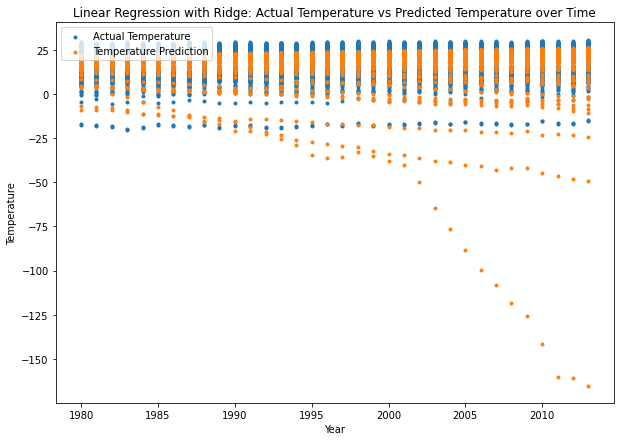

In [31]:
ridge_3_df = ridge_test_prediction_3.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(ridge_3_df['year'], ridge_3_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(ridge_3_df['year'], ridge_3_df['prediction'], label="Temperature Prediction", marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Linear Regression with Ridge: Actual Temperature vs Predicted Temperature over Time")
plt.show()

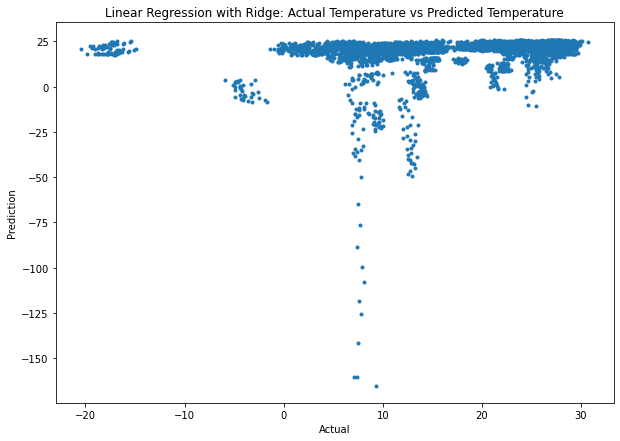

In [32]:
plt.figure(figsize=(10, 7))
plt.scatter(ridge_3_df['AvgYearlyTemp'], ridge_3_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression with Ridge: Actual Temperature vs Predicted Temperature")
plt.show()

###### Elastic Net

In [ ]:
# elastic net
elastic_3 = LinearRegression(featuresCol='features',labelCol='AvgYearlyTemp',maxIter=10, regParam=1, elasticNetParam = 1)
elasticModel_3 = elastic_3.fit(training_sdf)
elastic_training_prediction_3 = elasticModel_3.transform(training_sdf)
elastic_test_prediction_3 = elasticModel_3.transform(testing_sdf)
elastic_training_prediction_3_mse = evaluator.evaluate(lasso_training_prediction_3, {evaluator.metricName: "mse"})
elastic_training_prediction_3_mae = evaluator.evaluate(lasso_training_prediction_3, {evaluator.metricName: "mae"})
elastic_test_prediction_3_mse = evaluator.evaluate(elastic_test_prediction_3, {evaluator.metricName: "mse"})
elastic_test_prediction_3_mae = evaluator.evaluate(elastic_test_prediction_3, {evaluator.metricName: "mae"})

print("elastic training mse:", elastic_training_prediction_3_mse, '  elastic training mae:', elastic_training_prediction_3_mae)
print("    elastic test mse:", elastic_test_prediction_3_mse, '       elastic test mae:', elastic_test_prediction_3_mae)

elastic training mse: 62.974394026315075   elastic training mae: 6.373988062215199
    elastic test mse: 83.47466806694084        elastic test mae: 7.019691746254154


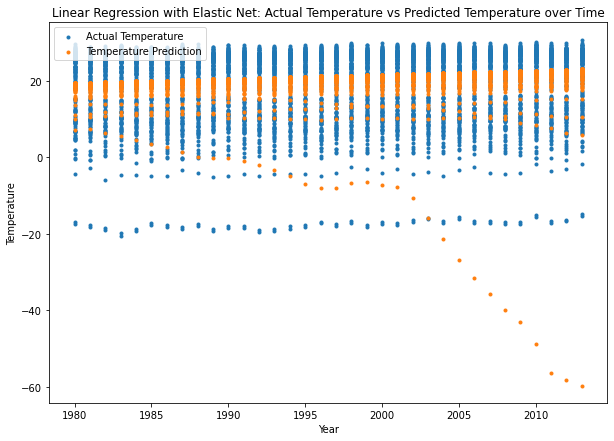

In [ ]:
elastic_3_df = elastic_test_prediction_3.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(elastic_3_df['year'], elastic_3_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(elastic_3_df['year'], elastic_3_df['prediction'], label="Temperature Prediction", marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Linear Regression with Elastic Net: Actual Temperature vs Predicted Temperature over Time")
plt.show()

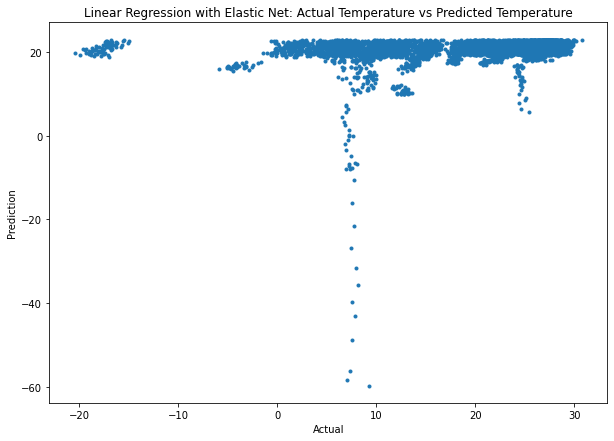

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(elastic_3_df['AvgYearlyTemp'], elastic_3_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression with Elastic Net: Actual Temperature vs Predicted Temperature")
plt.show()

#### Random Forest Regression

In [ ]:
# tuning RF model
from pyspark.ml.regression import RandomForestRegressor

max_Depth = [5, 10, 30]
num_Trees = [10, 30, 50]
for i in range(3):
  rfc = RandomForestRegressor(featuresCol="features",labelCol="AvgYearlyTemp", maxDepth = max_Depth[i], numTrees = num_Trees[i])
  rfModel = rfc.fit(training_sdf)
  rf_train_prediction = rfModel.transform(training_sdf)
  rf_test_prediction = rfModel.transform(testing_sdf)
  test_mse = evaluator.evaluate(rf_test_prediction, {evaluator.metricName: "mse"})
  test_mae = evaluator.evaluate(rf_test_prediction, {evaluator.metricName: "mae"})
  print("max depth:",max_Depth[i]," num trees:", num_Trees[i], " test mse:", test_mse, "test mae:", test_mae)

max depth: 5  num trees: 10  test mse: 62.57393626233615 test mae: 5.965007435331834
max depth: 10  num trees: 30  test mse: 41.43133466517697 test mae: 4.541345075620775
max depth: 30  num trees: 50  test mse: 39.46443266293471 test mae: 4.257612539436279


In [ ]:
rfc_3 = RandomForestRegressor(featuresCol="features",labelCol="AvgYearlyTemp", maxDepth = 30, numTrees=50)
rfModel_3 = rfc_3.fit(training_sdf)
rf_training_prediction_3 = rfModel_3.transform(training_sdf)
rf_test_prediction_3 = rfModel_3.transform(testing_sdf)
rf_training_prediction_mse_3 = evaluator.evaluate(rf_training_prediction_3, {evaluator.metricName: "mse"})
rf_training_prediction_mae_3 = evaluator.evaluate(rf_training_prediction_3, {evaluator.metricName: "mae"})
rf_test_prediction_mse_3 = evaluator.evaluate(rf_test_prediction_3, {evaluator.metricName: "mse"})
rf_test_prediction_mae_3 = evaluator.evaluate(rf_test_prediction_3, {evaluator.metricName: "mae"})

print("training mse:",rf_training_prediction_mse_3, "     training mae:", rf_training_prediction_mae_3)
print("    test mse:",rf_test_prediction_mse_3, "        test mae:", rf_test_prediction_mae_3)

training mse: 0.4384206272209074      training mae: 0.36610340089285914
    test mse: 39.46443266293471         test mae: 4.257612539436279


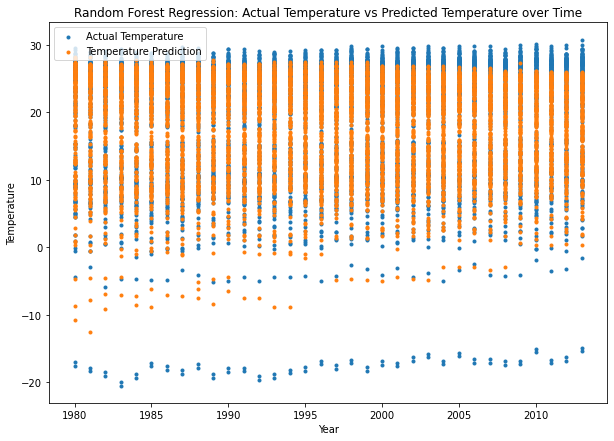

In [ ]:
rf_3_df = rf_test_prediction_3.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(rf_3_df['year'], rf_3_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(rf_3_df['year'], rf_3_df['prediction'], label="Temperature Prediction", marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("Random Forest Regression: Actual Temperature vs Predicted Temperature over Time")
plt.show()

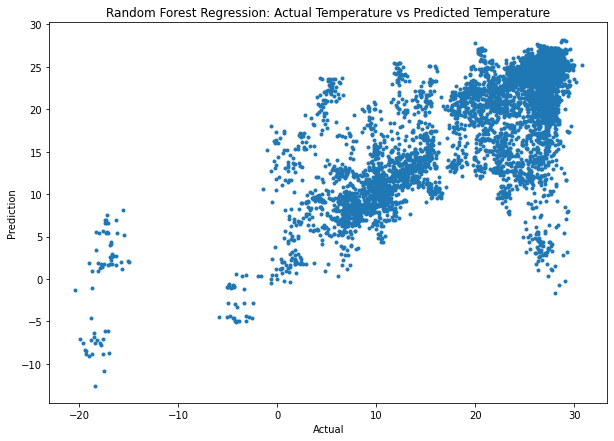

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(rf_3_df['AvgYearlyTemp'], rf_3_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Random Forest Regression: Actual Temperature vs Predicted Temperature")
plt.show()

### 4.3.2 Using PCA to reduce features

In [34]:
# split training x, y
training_df = training_sdf.toPandas()
training_x = training_df[['iso_code_labels', 'year', 'oil_co2_per_capita', 
            'oil_co2', 'share_global_oil_co2', 'cumulative_oil_co2',
            'share_global_cumulative_oil_co2', 'co2_growth_abs', 
            'co2_per_capita', 'co2', 'share_global_co2', 'cumulative_co2',
            'share_global_cumulative_co2', 'co2_growth_prct', 'population']]
training_y = training_df['AvgYearlyTemp']

# split test x, y
testing_df = testing_sdf.toPandas()
testing_x = testing_df[['iso_code_labels', 'year', 'oil_co2_per_capita', 
            'oil_co2', 'share_global_oil_co2', 'cumulative_oil_co2',
            'share_global_cumulative_oil_co2', 'co2_growth_abs', 
            'co2_per_capita', 'co2', 'share_global_co2', 'cumulative_co2',
            'share_global_cumulative_co2', 'co2_growth_prct', 'population']]
testing_y = testing_df['AvgYearlyTemp']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_training_x = scaler.fit_transform(training_x)
scaled_testing_x = scaler.transform(testing_x)

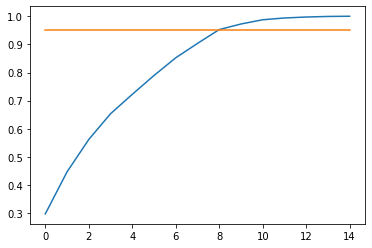

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
x_train_pca = pca.fit_transform(scaled_training_x)
x_test_pca = pca.transform(scaled_testing_x)
pca_components = pca.components_

# Explained variance
np.set_printoptions(suppress=True)
pca_ratio = pca.explained_variance_ratio_
plt.plot(np.arange(0, 15), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(0, 15), [0.95]*15)
plt.show()

#### Linear Regression

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA

pca_3 = PCA(k=8, inputCol="features", outputCol="pcaFeatures")

# Set up PCA using Elastic Net Linear Regression
pca_lr_3 = LinearRegression(featuresCol='pcaFeatures',labelCol='AvgYearlyTemp',maxIter=10, regParam=1, elasticNetParam = 1)

# Fit the model using the training data
pca_lr_pipe_3 = Pipeline(stages=[assembler,pca_3, pca_lr_3])
pca_lr_training_sdf_3 = training_sdf.drop("features")
pca_lr_model_3 = pca_lr_pipe_3.fit(pca_lr_training_sdf_3)
pca_lr_training_prediction_3 = pca_lr_model_3.transform(pca_lr_training_sdf_3)

pca_lr_test_sdf_3 = testing_sdf.drop("features")
pca_lr_test_prediction_3 = pca_lr_model_3.transform(pca_lr_test_sdf_3)
pca_lr_training_mse_3 = evaluator.evaluate(pca_lr_training_prediction_3, {evaluator.metricName: "mse"})
pca_lr_training_mae_3 = evaluator.evaluate(pca_lr_training_prediction_3, {evaluator.metricName: "mae"})
pca_lr_test_mse_3 = evaluator.evaluate(pca_lr_test_prediction_3, {evaluator.metricName: "mse"})
pca_lr_test_mae_3 = evaluator.evaluate(pca_lr_test_prediction_3, {evaluator.metricName: "mae"})
print("training mse:", pca_lr_training_mse_3, "   training mae:", pca_lr_training_mae_3)
print("    test mse:", pca_lr_test_mse_3, "       test mae:", pca_lr_test_mae_3)

training mse: 68.03505012415971    training mae: 6.860522774455722
    test mse: 86.23959818607524        test mae: 7.077655587825755


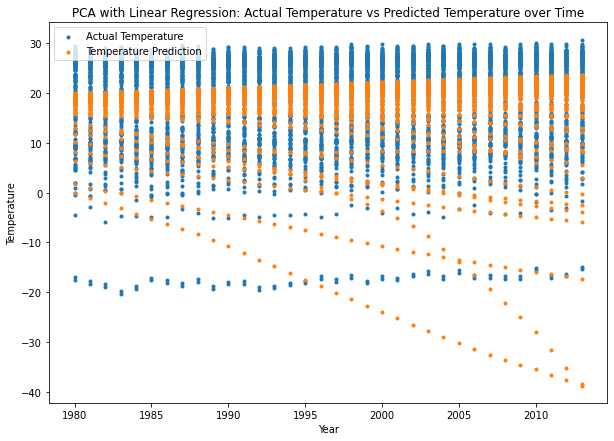

In [ ]:
pca_lr_3_df = pca_lr_test_prediction_3.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(pca_lr_3_df['year'], pca_lr_3_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(pca_lr_3_df['year'], pca_lr_3_df['prediction'], label="Temperature Prediction", marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("PCA with Linear Regression: Actual Temperature vs Predicted Temperature over Time")
plt.show()

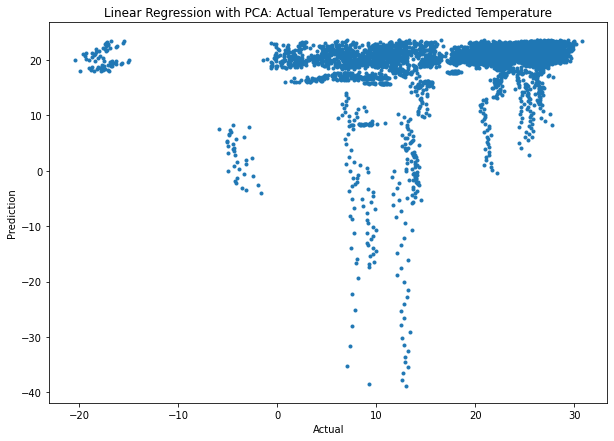

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_lr_3_df['AvgYearlyTemp'], pca_lr_3_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Linear Regression with PCA: Actual Temperature vs Predicted Temperature")
plt.show()

#### Random Forest Regression

In [ ]:
# Set up PCA using Random Forest Regression
pca_rf_3 = RandomForestRegressor(featuresCol="pcaFeatures",labelCol="AvgYearlyTemp", maxDepth = 30, numTrees=50)

# Fit the model using the training data
pca_rf_pipe_3 = Pipeline(stages=[assembler,pca_3, pca_rf_3])
pca_rf_training_sdf_3 = training_sdf.drop("features")
pca_rf_model_3 = pca_rf_pipe_3.fit(pca_rf_training_sdf_3)
pca_rf_training_prediction_3 = pca_rf_model_3.transform(pca_rf_training_sdf_3)

pca_rf_test_sdf_3 = testing_sdf.drop("features")
pca_rf_test_prediction_3 = pca_rf_model_3.transform(pca_lr_test_sdf_3)
pca_rf_training_mse_3 = evaluator.evaluate(pca_rf_training_prediction_3, {evaluator.metricName: "mse"})
pca_rf_training_mae_3 = evaluator.evaluate(pca_rf_training_prediction_3, {evaluator.metricName: "mae"})
pca_rf_test_mse_3 = evaluator.evaluate(pca_rf_test_prediction_3, {evaluator.metricName: "mse"})
pca_rf_test_mae_3 = evaluator.evaluate(pca_rf_test_prediction_3, {evaluator.metricName: "mae"})
print("training mse:", pca_rf_training_mse_3, "   training mae:", pca_rf_training_mae_3)
print("    test mse:", pca_rf_test_mse_3, "       test mae:", pca_rf_test_mae_3)

training mse: 0.49029574737666426    training mae: 0.41079503716926297
    test mse: 55.999343208612444        test mae: 5.450887773226152


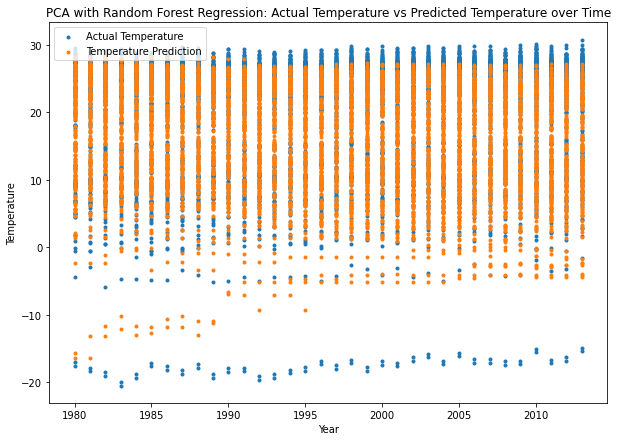

In [ ]:
pca_rf_3_df = pca_rf_test_prediction_3.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(pca_rf_3_df['year'], pca_rf_3_df['AvgYearlyTemp'], label = 'Actual Temperature', marker='.')
plt.scatter(pca_rf_3_df['year'], pca_rf_3_df['prediction'], label="Temperature Prediction", marker='.')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title("PCA with Random Forest Regression: Actual Temperature vs Predicted Temperature over Time")
plt.show()

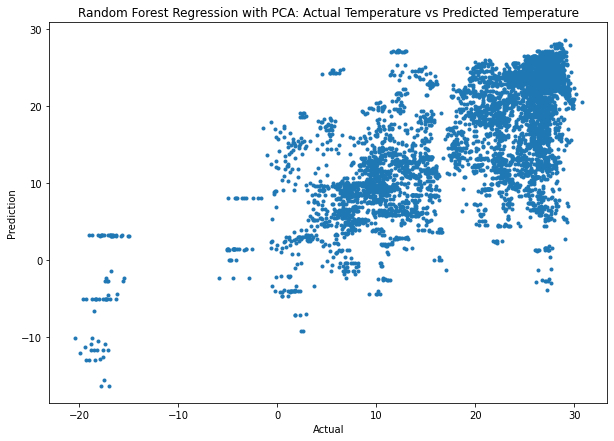

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_rf_3_df['AvgYearlyTemp'], pca_rf_3_df['prediction'], marker = '.')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Random Forest Regression with PCA: Actual Temperature vs Predicted Temperature")
plt.show()